# Business Understanding

Access to bank accounts enable households to save and make payments while also helping businesses build up their credit-worthiness and improve their access to loans, insurance, and related services. Therefore, access to bank accounts is an essential contributor to long-term economic growth.

The objective of this project is to create a machine learning model to predict which individuals are most likely to have or use a bank account. The models and solutions developed can provide an indication of the state of financial inclusion in Kenya, Rwanda, Tanzania and Uganda, while providing insights into some of the key factors driving individuals’ financial security.

## Stakeholder and Evaluation metric

*TBA*

# Basics

In [1]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.cluster import KMeans

RSEED=33

c = ['#599190', '#EDAFB8', '#666A86', '#95B8D1', '#E8DDB5']
color_cfm = ['#EAF2F2', '#D9E8E8', '#CCDFDF', '#BCD6D5', "#AACBCA", '#9AC1C1', '#83B3B2', '#77ABAA', '#6BA4A3', '#5F9C9A', '#599190']

In [2]:
# load data

original_train = pd.read_csv('data/Train.csv')
original_test = pd.read_csv('data/Test.csv')
variables = pd.read_csv('data/VariableDefinitions.csv')

In [3]:
variables

Variable Definitions                                         Unnamed: 1
0                  country                         Country interviewee is in.
1                     year                           Year survey was done in.
2                 uniqueid             Unique identifier for each interviewee
3            location_type                     Type of location: Rural, Urban
4         cellphone_access  If interviewee has access to a cellphone: Yes, No
5           household_size               Number of people living in one house
6        age_of_respondent                         The age of the interviewee
7     gender_of_respondent                Gender of interviewee: Male, Female
8   relationship_with_head  The interviewee’s relationship with the head o...
9           marital_status  The martial status of the interviewee: Married...
10         education_level  Highest level of education: No formal educatio...
11                job_type  Type of job interviewee has: Farming and Fishi...

In [4]:
original_train.columns = ["country", "year", "uniqueid", "bank_account", "location", "cellphone", "household", "age", "gender", "status_household", "marital_status", "education", "job"]
original_train.head(2)

country  year    uniqueid bank_account location cellphone  household  age  \
0   Kenya  2018  uniqueid_1          Yes    Rural       Yes          3   24   
1   Kenya  2018  uniqueid_2           No    Rural        No          5   70   

   gender   status_household           marital_status            education  \
0  Female             Spouse  Married/Living together  Secondary education   
1  Female  Head of Household                  Widowed  No formal education   

                    job  
0         Self employed  
1  Government Dependent

In [5]:
original_train.shape

(23524, 13)

In [6]:
# check for missing values 

original_train.isnull().sum()

country             0
year                0
uniqueid            0
bank_account        0
location            0
cellphone           0
household           0
age                 0
gender              0
status_household    0
marital_status      0
education           0
job                 0
dtype: int64

In [7]:
original_train.isna().sum()

country             0
year                0
uniqueid            0
bank_account        0
location            0
cellphone           0
household           0
age                 0
gender              0
status_household    0
marital_status      0
education           0
job                 0
dtype: int64

In [8]:
# check for unique values (to detect duplicates)

original_train.nunique()

country                4
year                   3
uniqueid            8735
bank_account           2
location               2
cellphone              2
household             20
age                   85
gender                 2
status_household       6
marital_status         5
education              6
job                   10
dtype: int64

In [9]:
original_train['uniqueid'].duplicated().sum()

14789

In [10]:
original_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   country           23524 non-null  object
 1   year              23524 non-null  int64 
 2   uniqueid          23524 non-null  object
 3   bank_account      23524 non-null  object
 4   location          23524 non-null  object
 5   cellphone         23524 non-null  object
 6   household         23524 non-null  int64 
 7   age               23524 non-null  int64 
 8   gender            23524 non-null  object
 9   status_household  23524 non-null  object
 10  marital_status    23524 non-null  object
 11  education         23524 non-null  object
 12  job               23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


# EDA

## Hypotheses 

Likeliness to have a bank account:

- country: more developed country higher than less developed country (Kenya, Tanzania, Rwanda, Uganda according to HDI)
- location_type: urban more likely than rural 
- cellphone_access: cellphone more likely than no cellphone
- household_size: the bigger the household, the less likely that this individual has a bank account (househould shares one account)
- age: younger more likely than older 
- gender: men/women balanced 
- relationship_with_head: head of household more likely than anyone else in family 
- marital_status: many different effects equal each other so the impact is low 
- education: higher education more likely than lower 
- job_level: higher job level more likely than lower 
- irrelevant: uniqueid, year

In [11]:
original_train.describe()

year     household           age
count  23524.000000  23524.000000  23524.000000
mean    2016.975939      3.797483     38.805220
std        0.847371      2.227613     16.520569
min     2016.000000      1.000000     16.000000
25%     2016.000000      2.000000     26.000000
50%     2017.000000      3.000000     35.000000
75%     2018.000000      5.000000     49.000000
max     2018.000000     21.000000    100.000000

In [12]:
original_train['bank_account'].value_counts(normalize=True)

No     0.859208
Yes    0.140792
Name: bank_account, dtype: float64

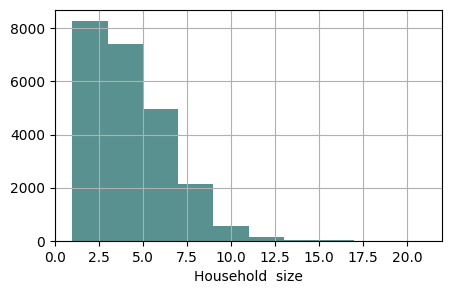

In [13]:
plt.figure(figsize=(5, 3))
original_train.household.hist(color='#599190') 
plt.xlabel('Household  size');

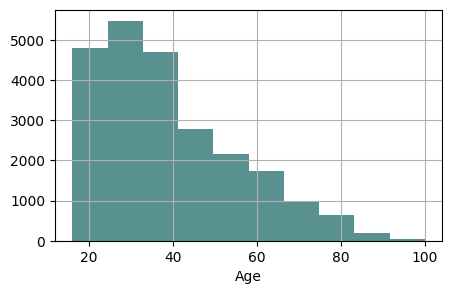

In [14]:
plt.figure(figsize=(5, 3))
original_train.age.hist(color='#599190') 
plt.xlabel('Age');

In [15]:
### add more plots about distributions here, see notebook "Johanna"

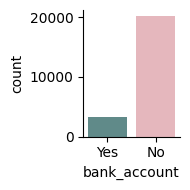

In [16]:
sns.catplot(x="bank_account", kind="count", data=original_train, height=2, palette=c)

In [17]:
features = ['country','location', 'cellphone','gender', 'status_household', 'marital_status','education', 'job']

for i in features:
    print(original_train[i].value_counts(normalize=True).round(2))

Rwanda      0.37
Tanzania    0.28
Kenya       0.26
Uganda      0.09
Name: country, dtype: float64
Rural    0.61
Urban    0.39
Name: location, dtype: float64
Yes    0.74
No     0.26
Name: cellphone, dtype: float64
Female    0.59
Male      0.41
Name: gender, dtype: float64
Head of Household      0.55
Spouse                 0.28
Child                  0.09
Parent                 0.05
Other relative         0.03
Other non-relatives    0.01
Name: status_household, dtype: float64
Married/Living together    0.46
Single/Never Married       0.34
Widowed                    0.12
Divorced/Seperated         0.09
Dont know                  0.00
Name: marital_status, dtype: float64
Primary education                  0.54
No formal education                0.19
Secondary education                0.18
Tertiary education                 0.05
Vocational/Specialised training    0.03
Other/Dont know/RTA                0.00
Name: education, dtype: float64
Self employed                   0.27
Informally empl

In [18]:
d = {}
for i in features:
    d[i] = pd.crosstab(original_train[i], original_train['bank_account'], normalize='index').mul(100).round(2)

In [19]:
d['country']

bank_account     No    Yes
country                   
Kenya         74.93  25.07
Rwanda        88.52  11.48
Tanzania      90.83   9.17
Uganda        91.39   8.61

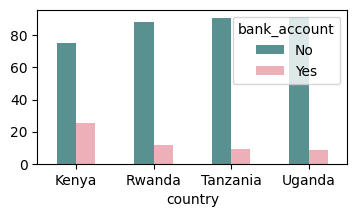

In [20]:
d['country'].plot.bar(figsize=(4,2), rot=0, color=c);

In [21]:
d['location']

bank_account     No    Yes
location                  
Rural         88.35  11.65
Urban         82.13  17.87

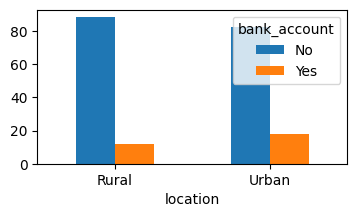

In [22]:
d['location'].plot.bar(figsize=(4,2), rot=0);

In [23]:
d['cellphone']

bank_account     No    Yes
cellphone                 
No            98.29   1.71
Yes           81.62  18.38

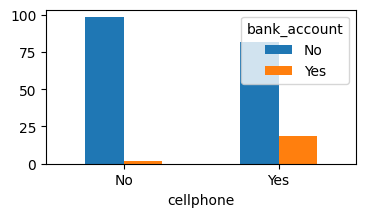

In [24]:
d['cellphone'].plot.bar(figsize=(4,2), rot=0);

In [25]:
d['gender']

bank_account     No    Yes
gender                    
Female        89.32  10.68
Male          81.03  18.97

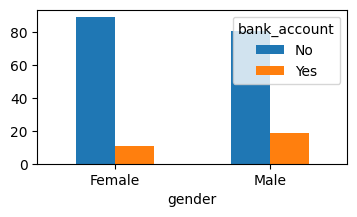

In [26]:
d['gender'].plot.bar(figsize=(4,2), rot=0);

In [27]:
d['status_household']

bank_account            No    Yes
status_household                 
Child                91.34   8.66
Head of Household    82.29  17.71
Other non-relatives  89.47  10.53
Other relative       90.12   9.88
Parent               94.01   5.99
Spouse               89.34  10.66

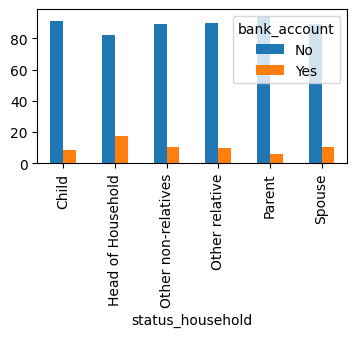

In [28]:
d['status_household'].plot.bar(figsize=(4,2), rot=90);

In [29]:
d['marital_status'].head(10)

bank_account                No    Yes
marital_status                       
Divorced/Seperated       88.73  11.27
Dont know                75.00  25.00
Married/Living together  82.64  17.36
Single/Never Married     87.90  12.10
Widowed                  90.99   9.01

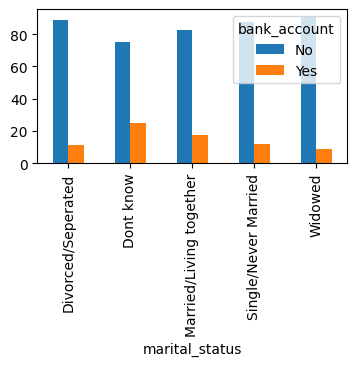

In [30]:
d['marital_status'].plot.bar(figsize=(4,2), rot=90);

In [31]:
d['education']

bank_account                        No    Yes
education                                    
No formal education              96.10   3.90
Other/Dont know/RTA              68.57  31.43
Primary education                91.45   8.55
Secondary education              76.72  23.28
Tertiary education               48.92  51.08
Vocational/Specialised training  42.96  57.04

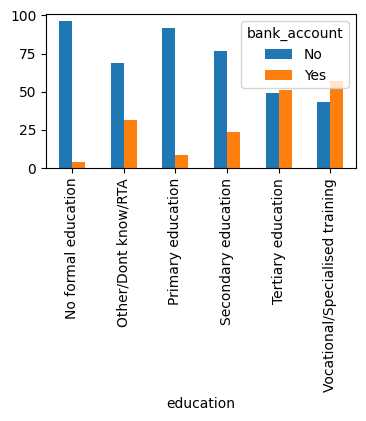

In [32]:
d['education'].plot.bar(figsize=(4,2), rot=90);

In [33]:
d['job']

bank_account                     No    Yes
job                                       
Dont Know/Refuse to answer    88.89  11.11
Farming and Fishing           88.33  11.67
Formally employed Government  22.48  77.52
Formally employed Private     45.88  54.12
Government Dependent          79.76  20.24
Informally employed           92.05   7.95
No Income                     97.93   2.07
Other Income                  81.85  18.15
Remittance Dependent          90.50   9.50
Self employed                 86.83  13.17

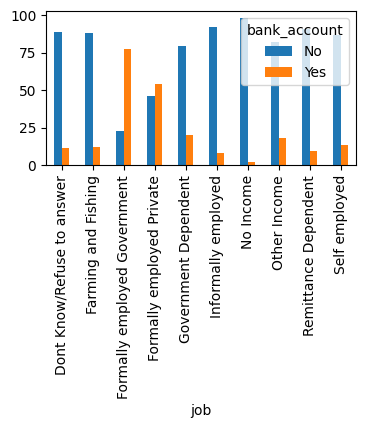

In [34]:
d['job'].plot.bar(figsize=(4,2), rot=90);

In [35]:
df_edu_job = pd.crosstab(original_train['job'], original_train['education'], normalize='index').mul(100).round(2)
df_edu_job.head(10)

education                     No formal education  Other/Dont know/RTA  \
job                                                                      
Dont Know/Refuse to answer                  14.29                 0.00   
Farming and Fishing                         25.82                 0.00   
Formally employed Government                 1.03                 0.52   
Formally employed Private                    3.13                 0.19   
Government Dependent                        53.04                 0.40   
Informally employed                         20.19                 0.29   
No Income                                   18.50                 0.48   
Other Income                                17.04                 0.28   
Remittance Dependent                        19.55                 0.08   
Self employed                               15.54                 0.09   

education                     Primary education  Secondary education  \
job                                                                    
Dont Know/Refuse to answer                59.52                23.81   
Farming and Fishing                       55.25                16.21   
Formally employed Government              10.85                33.59   
Formally employed Private                 31.00                25.12   
Government Dependent                      37.25                 3.64   
Informally employed                       60.87                14.11   
No Income                                 49.92                22.49   
Other Income                              47.78                26.39   
Remittance Dependent                      37.87                31.78   
Self employed                             63.01                13.80   

education                     Tertiary education  \
job                                                
Dont Know/Refuse to answer                  1.59   
Farming and Fishing                         0.97   
Formally employed Government               31.27   
Formally employed Private                  21.23   
Government Dependent                        3.24   
Informally employed                         3.14   
No Income                                   7.50   
Other Income                                4.35   
Remittance Dependent                        6.89   
Self employed                               4.74   

education                     Vocational/Specialised training  
job                                                            
Dont Know/Refuse to answer                               0.79  
Farming and Fishing                                      1.75  
Formally employed Government                            22.74  
Formally employed Private                               19.34  
Government Dependent                                     2.43  
Informally employed                                      1.39  
No Income                                                1.12  
Other Income                                             4.17  
Remittance Dependent                                     3.84  
Self employed                                            2.83

<AxesSubplot:xlabel='job'>

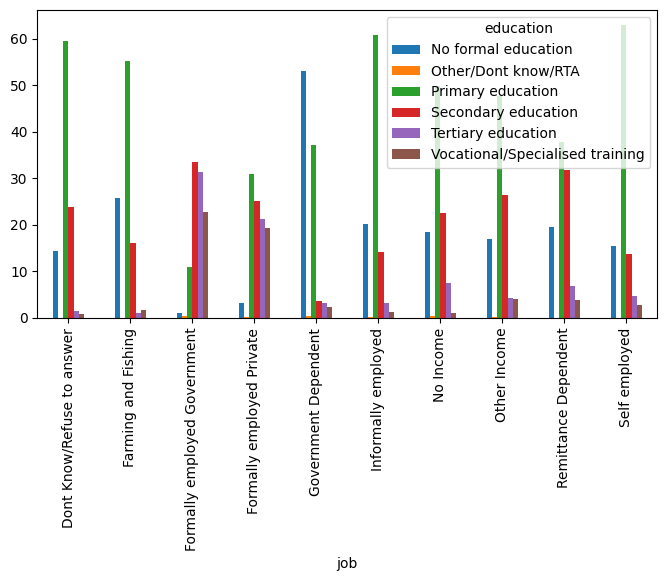

In [36]:
df_edu_job.plot.bar(figsize=(8,4), rot=90)

## Clustering

In [84]:
from sklearn import preprocessing

bank_customers = original_train.loc[(original_scaled.bank_account == "Yes")]
bank_customers_scaled = bank_customers.drop(['country', 'year', 'uniqueid'], axis=1)
scaler = preprocessing.MinMaxScaler()
bank_customers_scaled[['age','household']] = scaler.fit_transform(bank_customers[['age','household']])

In [86]:
bank_customers_scaled.shape

(3312, 10)

In [87]:
bank_customers_scaled2 = bank_customers_scaled.drop(['bank_account'], axis=1)

In [49]:
from kmodes.kprototypes import KPrototypes

this takes too long

```
cost = []
K = range(1,6)
for num_clusters in list(K):
    kproto = KPrototypes (n_clusters=num_clusters, init = "Cao", n_init = 5, verbose=1)
    kproto.fit_predict(bank_customers, categorical=[0,1,4,5,6,7,8])
    cost.append(kproto.cost_)
```

In [50]:
# cost for categorical = [0,1,4,5,6,7,8]

K = range(1,6)
cost = [861.9096379127745,
 706.6471529581682,
 626.3374351760665,
 581.6180868797991,
 556.8295447906916]

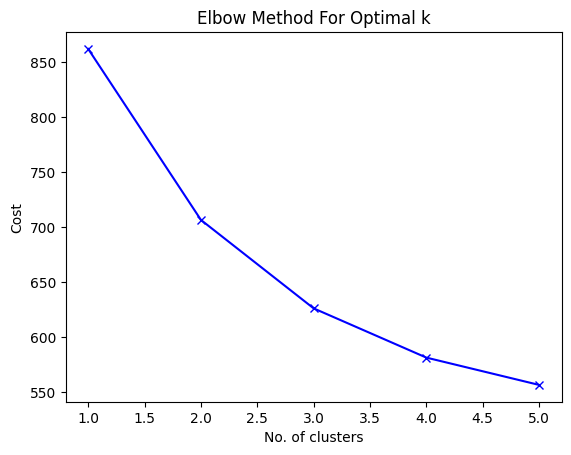

In [44]:
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [89]:
kproto = KPrototypes(n_clusters=4, init='Cao')
clusters = kproto.fit_predict(bank_customers_scaled2, categorical=[0,1,4,5,6,7,8])

In [90]:
clusters.shape

(3312,)

In [93]:
bank_customers.reset_index(drop=True, inplace=True)

In [94]:
bank_customers

country  year       uniqueid bank_account location cellphone  household  \
0      Kenya  2018     uniqueid_1          Yes    Rural       Yes          3   
1      Kenya  2018     uniqueid_3          Yes    Urban       Yes          5   
2      Kenya  2018     uniqueid_9          Yes    Rural       Yes          3   
3      Kenya  2018    uniqueid_12          Yes    Rural       Yes          3   
4      Kenya  2018    uniqueid_18          Yes    Rural       Yes          6   
...      ...   ...            ...          ...      ...       ...        ...   
3307  Uganda  2018  uniqueid_1905          Yes    Urban       Yes          1   
3308  Uganda  2018  uniqueid_1909          Yes    Rural       Yes          3   
3309  Uganda  2018  uniqueid_1929          Yes    Rural       Yes          5   
3310  Uganda  2018  uniqueid_1936          Yes    Rural       Yes         10   
3311  Uganda  2018  uniqueid_1940          Yes    Urban        No          7   

      age  gender   status_household           marital_status  \
0      24  Female             Spouse  Married/Living together   
1      26    Male     Other relative     Single/Never Married   
2      54    Male  Head of Household  Married/Living together   
3      69    Male  Head of Household  Married/Living together   
4      27  Female  Head of Household  Married/Living together   
...   ...     ...                ...                      ...   
3307   24  Female  Head of Household     Single/Never Married   
3308   26  Female  Head of Household  Married/Living together   
3309   36  Female  Head of Household                  Widowed   
3310   50  Female  Head of Household                  Widowed   
3311   18  Female             Parent     Single/Never Married   

                            education                  job  
0                 Secondary education        Self employed  
1     Vocational/Specialised training        Self employed  
2                 Secondary education  Farming and Fishing  
3                 Secondary education         Other Income  
4                 Secondary education        Self employed  
...                               ...                  ...  
3307              Secondary education         Other Income  
3308              Secondary education         Other Income  
3309                Primary education            No Income  
3310                Primary education        Self employed  
3311              Secondary education         Other Income  

[3312 rows x 13 columns]

In [95]:
df_cluster = pd.Series(clusters, name='Cluster')
df_clustered = pd.concat([bank_customers, df_cluster], axis=1)

In [96]:
df_clustered

country  year       uniqueid bank_account location cellphone  household  \
0      Kenya  2018     uniqueid_1          Yes    Rural       Yes          3   
1      Kenya  2018     uniqueid_3          Yes    Urban       Yes          5   
2      Kenya  2018     uniqueid_9          Yes    Rural       Yes          3   
3      Kenya  2018    uniqueid_12          Yes    Rural       Yes          3   
4      Kenya  2018    uniqueid_18          Yes    Rural       Yes          6   
...      ...   ...            ...          ...      ...       ...        ...   
3307  Uganda  2018  uniqueid_1905          Yes    Urban       Yes          1   
3308  Uganda  2018  uniqueid_1909          Yes    Rural       Yes          3   
3309  Uganda  2018  uniqueid_1929          Yes    Rural       Yes          5   
3310  Uganda  2018  uniqueid_1936          Yes    Rural       Yes         10   
3311  Uganda  2018  uniqueid_1940          Yes    Urban        No          7   

      age  gender   status_household           marital_status  \
0      24  Female             Spouse  Married/Living together   
1      26    Male     Other relative     Single/Never Married   
2      54    Male  Head of Household  Married/Living together   
3      69    Male  Head of Household  Married/Living together   
4      27  Female  Head of Household  Married/Living together   
...   ...     ...                ...                      ...   
3307   24  Female  Head of Household     Single/Never Married   
3308   26  Female  Head of Household  Married/Living together   
3309   36  Female  Head of Household                  Widowed   
3310   50  Female  Head of Household                  Widowed   
3311   18  Female             Parent     Single/Never Married   

                            education                  job  Cluster  
0                 Secondary education        Self employed        2  
1     Vocational/Specialised training        Self employed        3  
2                 Secondary education  Farming and Fishing        0  
3                 Secondary education         Other Income        0  
4                 Secondary education        Self employed        2  
...                               ...                  ...      ...  
3307              Secondary education         Other Income        3  
3308              Secondary education         Other Income        2  
3309                Primary education            No Income        1  
3310                Primary education        Self employed        0  
3311              Secondary education         Other Income        2  

[3312 rows x 14 columns]

In [97]:
df_clustered['Segment'] = df_clustered['Cluster'].map({0:'First', 1:'Second', 2:'Third', 3: 'Fourth'})
df_clustered['Segment'] = df_clustered['Segment'].astype('category')

df_clustered.groupby('Segment').agg(
    {'Cluster':'count',
    'location': lambda x: x.value_counts().index[0],
    'cellphone': lambda x: x.value_counts().index[0],
    'household': 'mean',
    'age': 'mean',
    'gender': lambda x: x.value_counts().index[0],
    'status_household': lambda x: x.value_counts().index[0],
    'marital_status': lambda x: x.value_counts().index[0],
    'education': lambda x: x.value_counts().index[0],
    'job': lambda x: x.value_counts().index[0],
    }
).reset_index()

Segment  Cluster location cellphone  household        age  gender  \
0   First     1103    Rural       Yes   4.393472  41.878513    Male   
1  Fourth      954    Urban       Yes   2.430818  32.119497    Male   
2  Second      421    Rural       Yes   3.026128  62.570071  Female   
3   Third      834    Urban       Yes   4.342926  33.540767  Female   

    status_household           marital_status            education  \
0  Head of Household  Married/Living together    Primary education   
1  Head of Household     Single/Never Married   Tertiary education   
2  Head of Household                  Widowed    Primary education   
3             Spouse  Married/Living together  Secondary education   

                         job  
0              Self employed  
1  Formally employed Private  
2        Farming and Fishing  
3              Self employed

### Data Cleaning, Preprocessing #1

In [42]:
original_train.head(2)

country  year    uniqueid bank_account location cellphone  household  age  \
0   Kenya  2018  uniqueid_1          Yes    Rural       Yes          3   24   
1   Kenya  2018  uniqueid_2           No    Rural        No          5   70   

   gender   status_household           marital_status            education  \
0  Female             Spouse  Married/Living together  Secondary education   
1  Female  Head of Household                  Widowed  No formal education   

                    job  
0         Self employed  
1  Government Dependent

In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [44]:
#convert target variable to numeric
le = LabelEncoder()
original_train['bank_account'] = le.fit_transform(original_train['bank_account'])

In [45]:
#Separate training features from target
X_train = original_train.drop(['bank_account'], axis=1)
y_train = original_train['bank_account']

In [46]:
# this has to be repeated for original_test!

X_train = X_train.drop(["uniqueid", "year"], axis=1)

country_dummies = pd.get_dummies(X_train['country'], prefix='country', drop_first=True)
location_dummies = pd.get_dummies(X_train['location'], prefix='location', drop_first=True)
cellphone_dummies = pd.get_dummies(X_train['cellphone'], prefix='cellphone', drop_first=True)
gender_dummies = pd.get_dummies(X_train['gender'], prefix='gender', drop_first=True)
marital_status_dummies = pd.get_dummies(X_train['marital_status'], prefix='marital_status', drop_first=True)
job_dummies = pd.get_dummies(X_train['job'], prefix='job', drop_first=True)
status_household_dummies = pd.get_dummies(X_train['status_household'], prefix='status_household', drop_first=True)

X_train = pd.concat([X_train, country_dummies, location_dummies, cellphone_dummies, gender_dummies, marital_status_dummies, job_dummies, status_household_dummies], axis=1)

edu_mapping = {'No formal education': 0, 
               'Primary education' : 2, 
               'Other/Dont know/RTA': 1,
               'Vocational/Specialised training': 4, 
               'Secondary education': 3, 
               'Tertiary education' : 5}

X_train = X_train.assign(edu_cat = X_train.education.map(edu_mapping))

X_train = X_train.drop(['country', 'location', 'cellphone', 'gender', 'marital_status', 'education', 'job', 'status_household'], axis=1)

scaler = MinMaxScaler(feature_range=(0, 1))
columns_to_scale = ['household', 'age', 'country_Rwanda', 'country_Tanzania',
       'country_Uganda', 'location_Urban', 'cellphone_Yes', 'gender_Male',
       'marital_status_Dont know', 'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'job_Farming and Fishing', 'job_Formally employed Government',
       'job_Formally employed Private', 'job_Government Dependent',
       'job_Informally employed', 'job_No Income', 'job_Other Income',
       'job_Remittance Dependent', 'job_Self employed',
       'status_household_Head of Household',
       'status_household_Other non-relatives',
       'status_household_Other relative', 'status_household_Parent',
       'status_household_Spouse', 'edu_cat']
processed_X_train = scaler.fit_transform(X_train[columns_to_scale])

# Train Test Split (stratified)

In [47]:
X_Train, X_Val, y_Train, y_Val = train_test_split(processed_X_train, y_train, stratify = y_train, 
                                                  test_size = 0.2, random_state=RSEED)

# Baseline Model 1 Simple decision tree

In [48]:
Tree = DecisionTreeClassifier(criterion='gini', max_depth=15, random_state=RSEED)
Tree.fit(X_Train, y_Train) 

DecisionTreeClassifier(max_depth=15, random_state=33)

In [49]:
y_pred_Train_tree = Tree.predict(X_Train)
y_pred_Val_tree = Tree.predict(X_Val)

In [50]:
print('Accuracy Train: ',metrics.accuracy_score(y_Train, y_pred_Train_tree))
print('Accuracy Test: ',metrics.accuracy_score(y_Val, y_pred_Val_tree))
print('F1-score Train: ',metrics.f1_score(y_Train, y_pred_Train_tree, pos_label=1))
print('F1-score Test: ',metrics.f1_score(y_Val, y_pred_Val_tree, pos_label=1))
print('Recall Train: ',metrics.recall_score(y_Train, y_pred_Train_tree, pos_label=1))
print('Recall Test: ',metrics.recall_score(y_Val, y_pred_Val_tree, pos_label=1))

Accuracy Train:  0.9323024602795048
Accuracy Test:  0.8650371944739639
F1-score Train:  0.7021972884525479
F1-score Test:  0.40709617180205415
Recall Train:  0.5667924528301886
Recall Test:  0.3293051359516616


In [76]:
cfm_tree = metrics.confusion_matrix(y_Val, y_pred_Val_tree)

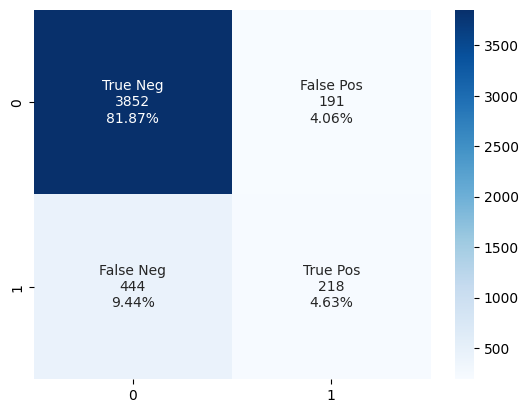

In [77]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_tree.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_tree.flatten()/np.sum(cfm_tree)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_tree, annot=labels, fmt='', cmap='Blues');

# Baseline Model 2 Logistic Regression

In [52]:
logreg = LogisticRegression(random_state=RSEED)
logreg.fit(X_Train, y_Train) 

LogisticRegression(random_state=33)

In [53]:
y_pred_Train_log = logreg.predict(X_Train)
y_pred_Val_log = logreg.predict(X_Val)

In [54]:
print('Accuracy Train: ',metrics.accuracy_score(y_Train, y_pred_Train_log))
print('Accuracy Test: ',metrics.accuracy_score(y_Val, y_pred_Val_log))
print('F1-score Train: ',metrics.f1_score(y_Train, y_pred_Train_log, pos_label=1))
print('F1-score Test: ',metrics.f1_score(y_Val, y_pred_Val_log, pos_label=1))
print('Recall Train: ',metrics.recall_score(y_Train, y_pred_Train_log, pos_label=1))
print('Recall Test: ',metrics.recall_score(y_Val, y_pred_Val_log, pos_label=1))

Accuracy Train:  0.8859131728572188
Accuracy Test:  0.8801275239107332
F1-score Train:  0.449345986150295
F1-score Test:  0.4088050314465409
Recall Train:  0.3305660377358491
Recall Test:  0.2945619335347432


In [55]:
cfm_log = metrics.confusion_matrix(y_Val, y_pred_Val_log)

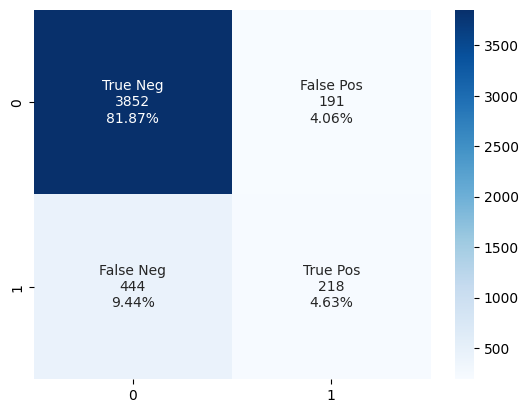

In [67]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_tree.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_tree.flatten()/np.sum(cfm_tree)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_tree, annot=labels, fmt='', cmap='Blues');

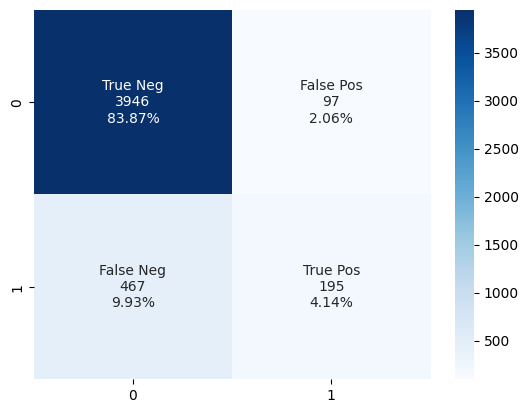

In [56]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_log.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_log.flatten()/np.sum(cfm_log)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_log, annot=labels, fmt='', cmap='Blues');

# Baseline Model 3 Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = RSEED)
rf.fit(X_Train, y_Train) 

RandomForestClassifier(n_estimators=1000, random_state=33)

In [69]:
y_pred_Train_rf = rf.predict(X_Train)
y_pred_Val_rf = rf.predict(X_Val)

In [73]:
print('Accuracy Train: ',metrics.accuracy_score(y_Train, y_pred_Train_rf))
print('Accuracy Test: ',metrics.accuracy_score(y_Val, y_pred_Val_rf))
print('F1-score Train: ',metrics.f1_score(y_Train, y_pred_Train_rf, pos_label=1))
print('F1-score Test: ',metrics.f1_score(y_Val, y_pred_Val_rf, pos_label=1))
print('Recall Train: ',metrics.recall_score(y_Train, y_pred_Train_rf, pos_label=1))
print('Recall Test: ',metrics.recall_score(y_Val, y_pred_Val_rf, pos_label=1))
print('Precision Train: ',metrics.precision_score(y_Train, y_pred_Train_rf, pos_label=1))
print('Precision Test: ',metrics.precision_score(y_Val, y_pred_Val_rf, pos_label=1))

Accuracy Train:  0.9799139167862266
Accuracy Test:  0.867375132837407
F1-score Train:  0.9249404289118347
F1-score Test:  0.42857142857142855
Recall Train:  0.8788679245283019
Recall Test:  0.35347432024169184
Precision Train:  0.9761106454316848
Precision Test:  0.5441860465116279


In [74]:
cfm_rf = metrics.confusion_matrix(y_Val, y_pred_Val_rf)

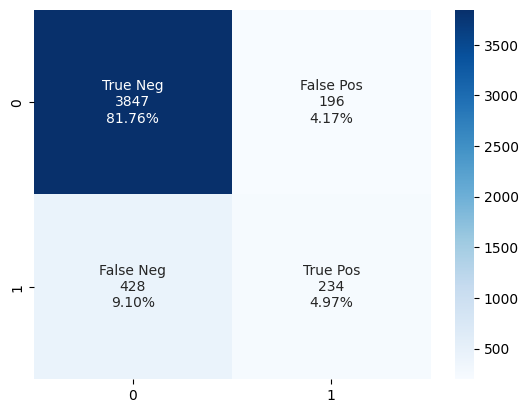

In [75]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_rf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_rf.flatten()/np.sum(cfm_rf)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_rf, annot=labels, fmt='', cmap='Blues');